In [1]:
import scipy.io
import os
import shutil
try:
    from urllib import urlretrieve # python2
except:
    from urllib.request import urlretrieve # python3


In [2]:
import data as data
import numpy as np
import matplotlib.pyplot as plt
import torch as T
import torch
device = T.device("cuda")  # apply to Tensor or Module
import time
from tqdm import tqdm
from train_objectives import SAD, SID

In [3]:
torch.cuda.empty_cache()

In [4]:
mat = scipy.io.loadmat( 'PaviaU.mat' )
img = mat[ 'paviaU' ]

# create a hyperspectral dataset object from the numpy array
hypData = data.HypImg( img )

# pre-process data to make the model easier to train
hypData.pre_process( 'minmax' )

In [5]:
# create data iterator objects for training and validation using the pre-processed data
trainSamples = 200000
valSamples = 100
dataTrain = data.Iterator( dataSamples=hypData.spectraPrep[:trainSamples, :],
                        targets=hypData.spectraPrep[:trainSamples, :], batchSize=4 )
dataVal = data.Iterator( dataSamples=hypData.spectraPrep[trainSamples:trainSamples+valSamples, :],
                        targets=hypData.spectraPrep[trainSamples:trainSamples+valSamples, :] )


In [6]:
# shuffle training data
dataTrain.shuffle()

In [7]:
train_data = torch.tensor(dataTrain.dataSamples.astype(np.float32))
train_data

tensor([[2.1668e-01, 9.5756e-02, 9.3786e-03,  ..., 5.7206e-01, 5.8144e-01,
         6.1698e-01],
        [5.8316e-02, 1.4759e-02, 3.7077e-02,  ..., 7.1454e-01, 7.2822e-01,
         7.4550e-01],
        [1.3724e-01, 8.3258e-02, 1.4182e-02,  ..., 3.7694e-01, 3.5224e-01,
         3.6139e-01],
        ...,
        [2.3950e-01, 1.5355e-01, 4.9735e-02,  ..., 7.9237e-01, 8.0396e-01,
         8.2810e-01],
        [5.7971e-07, 7.0725e-02, 5.7392e-02,  ..., 3.8377e-01, 3.8551e-01,
         3.6116e-01],
        [4.5725e-07, 1.4632e-02, 8.2305e-02,  ..., 3.8775e-01, 4.0832e-01,
         4.2707e-01]])

In [8]:
hypData.numBands
encoderSize=[50,30,10]
encoderSize=[hypData.numBands]+encoderSize
decodersize=encoderSize[::-1]
encoderSize,decodersize

([103, 50, 30, 10], [10, 30, 50, 103])

In [9]:
def force_cudnn_initialization():
    s = 32
    dev = torch.device('cuda')
    torch.nn.functional.conv2d(torch.zeros(s, s, s, s, device=dev), torch.zeros(s, s, s, s, device=dev))

In [10]:
# -----------------------------------------------------------

class Net(T.nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.enn1 = T.nn.Linear(103, 50)  # 64-16-2-16-64
    self.enn2 = T.nn.Linear(50, 30)
    self.enn3 = T.nn.Linear(30,10)
    self.dnn3 = T.nn.Linear(10, 30)  # 64-16-2-16-64
    self.dnn2 = T.nn.Linear(30, 50)
    self.dnn1 = T.nn.Linear(50,103)

  def encoder(self,x):
    z= T.relu(self.enn1(x))
    z= T.relu(self.enn2(z))
    z= T.relu(self.enn3(z))
    return z
  
  def decoder(self,x):
    z= T.relu(self.dnn3(x))
    z= T.relu(self.dnn2(z))
    z= self.dnn1(z)
    return z


  def forward(self, x):
    encoded=self.encoder(x)
    decoded= self.decoder(encoded)
    
    return encoded,decoded
    
net=Net().to(device)


In [11]:

inpu=torch.rand(1,103).to(device)
outp=net(inpu)
outp[1].shape


torch.Size([1, 103])

In [12]:
hypData.numBands

103

In [16]:
# -----------------------------------------------------------

force_cudnn_initialization()
# 0. setup
print("\nBegin UCI digits auto-reduce-viz demo job ")
T.manual_seed(1)
np.random.seed(1)

bat_size = 8184
train_ldr = T.utils.data.DataLoader(train_data,
batch_size=bat_size, shuffle=True)
  # 2. create network
print("\nCreating 64-16-2-16-63 autoencoder ")
net = Net().to("cuda:0")

# 3. train model
max_epochs = 1300
ep_log_interval = 5
lrn_rate = 0.0001

loss_func1 = T.nn.MSELoss()
loss_func = SAD()
optimizer = T.optim.Adam(net.parameters(), lr=lrn_rate)

print("\nbat_size = %3d " % bat_size)
print("loss = " + str(loss_func))
print("optimizer = Adam")
print("max_epochs = %3d " % max_epochs)
print("lrn_rate = %0.3f " % lrn_rate)

print("\nStarting training")
net = net.train()


for epoch in range(0, max_epochs):
  time.sleep(0.5)
  loop= tqdm(enumerate(train_ldr), total=len(train_ldr),leave=True)
  epoch_loss = 0  # for one full epoch
  mseloss=0

  iterator = iter(train_ldr)
  
  for (batch_idx, batch) in loop:
    Z = next(iterator)
    Z = Z.view(Z.size()[0], -1)
    Z = Z.cuda()
    
    enc_out, dec_out = net(Z.float())
    loss1 = loss_func(dec_out, Z.float())  
    loss1 = torch.sum(loss1).float()
    optimizer.zero_grad()
    loss1.backward()
    optimizer.step()
    
    X = batch.to(device)  # no targets needed
    
    '''optimizer.zero_grad()
    oupt = net(X)
    loss_obj = loss_func(oupt[1], X)  # note: X not Y'''
    #loss_obj1=loss_func1(oupt[1],X)
    epoch_loss += loss1.item()  # accumulate
    #mseloss+=loss_obj1.item()
    #loss_obj.backward()
    #optimizer.step()
    
    loop.set_description(f"Epoch [{epoch}/{max_epochs}]")
    loop.set_postfix(loss=str(epoch_loss))

    

  #if epoch % ep_log_interval == 0:
    
    
    #print("epoch = %4d   loss = %0.4f" % (epoch, epoch_loss)) 
print("Done ")

# 4. plot digits using reduced form
print("\nCreating graph from encoded data ")
net = net.eval()






Begin UCI digits auto-reduce-viz demo job 

Creating 64-16-2-16-63 autoencoder 

bat_size = 8184 
loss = SAD()
optimizer = Adam
max_epochs = 1300 
lrn_rate = 0.000 

Starting training


Epoch [180/1300]: 100%|██████████| 25/25 [00:01<00:00, 15.28it/s, loss=13306.61572265625] 


Epoch [360/1300]: 100%|██████████| 25/25 [00:01<00:00, 15.12it/s, loss=11275.4091796875]  


Epoch [540/1300]: 100%|██████████| 25/25 [00:01<00:00, 15.18it/s, loss=10314.595794677734]


Epoch [720/1300]: 100%|██████████| 25/25 [00:01<00:00, 15.20it/s, loss=9909.229919433594] 


Epoch [900/1300]: 100%|██████████| 25/25 [00:01<00:00, 15.40it/s, loss=9824.542114257812] 


Epoch [1079/1300]: 100%|██████████| 25/25 [00:01<00:00, 15.49it/s, loss=9791.856185913086] 


Epoch [1257/1300]: 100%|██████████| 25/25 [00:01<00:00, 14.90it/s, loss=9764.072402954102] 


Epoch [1299/1300]: 100%|██████████| 25/25 [00:01<00:00, 15.29it/s, loss=9758.96484375]     

Done 

Creating graph from encoded data 


In [18]:

torch.save(net, 'model_sad_2000.pth')

In [19]:
torch.save(net.state_dict(), 'net_model_sad.pth')

In [13]:
net.load_state_dict(torch.load('net_model_sad.pth'))

<All keys matched successfully>

In [14]:
trex=torch.tensor(hypData.spectraPrep.astype(np.float32))
trex

tensor([[0.1428, 0.1011, 0.0913,  ..., 0.8679, 0.8727, 0.8761],
        [0.1670, 0.1465, 0.1398,  ..., 0.8144, 0.8221, 0.8447],
        [0.2236, 0.2766, 0.1961,  ..., 0.9382, 0.9538, 0.9606],
        ...,
        [0.1139, 0.0292, 0.0460,  ..., 0.8492, 0.8594, 0.8660],
        [0.1068, 0.1744, 0.1333,  ..., 0.8415, 0.8397, 0.8316],
        [0.2278, 0.1603, 0.0520,  ..., 0.8381, 0.8505, 0.8657]])

In [15]:
dataZ=net.encoder(trex.to("cuda"))
dataZ

tensor([[0.7041, 0.0000, 0.0000,  ..., 1.1637, 0.0000, 3.2466],
        [0.7217, 0.0000, 0.0000,  ..., 1.3351, 0.0000, 3.3457],
        [0.7099, 0.0000, 0.0000,  ..., 1.3203, 0.0000, 3.2062],
        ...,
        [0.6689, 0.0000, 0.0000,  ..., 1.6667, 0.0000, 3.8806],
        [0.6299, 0.0000, 0.0000,  ..., 1.6903, 0.0000, 3.7466],
        [0.6034, 0.0000, 0.0000,  ..., 1.5922, 0.0000, 3.6888]],
       device='cuda:0', grad_fn=<ReluBackward0>)

In [16]:
dataY = net.decoder(dataZ)
dataY

tensor([[0.0475, 0.0423, 0.0361,  ..., 0.3087, 0.3098, 0.3121],
        [0.0570, 0.0556, 0.0530,  ..., 0.2958, 0.2966, 0.2981],
        [0.0876, 0.0736, 0.0585,  ..., 0.3058, 0.3068, 0.3097],
        ...,
        [0.0296, 0.0206, 0.0140,  ..., 0.2757, 0.2778, 0.2809],
        [0.0486, 0.0401, 0.0331,  ..., 0.2674, 0.2694, 0.2717],
        [0.0762, 0.0505, 0.0233,  ..., 0.2791, 0.2807, 0.2831]],
       device='cuda:0', grad_fn=<AddmmBackward0>)

In [17]:
imgZ = np.reshape(dataZ.to("cpu").detach().numpy(), (hypData.numRows, hypData.numCols, -1))

In [18]:
imgY = np.reshape(dataY.to("cpu").detach().numpy(), (hypData.numRows, hypData.numCols, -1))

In [19]:
imgX = np.reshape(hypData.spectraPrep, (hypData.numRows, hypData.numCols, -1))

In [20]:
# visualise latent image using 3 out of the 10 dimensions
colourImg = imgZ.copy()
colourImg = colourImg[ :,:,np.argsort(-np.std(np.std(colourImg, axis=0), axis=0))[:3] ]
colourImg /= np.max(np.max(colourImg, axis=0), axis=0)

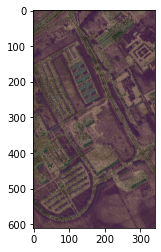

In [21]:
plt.imshow(colourImg)

Text(0.5, 1.0, 'meadow spectra')

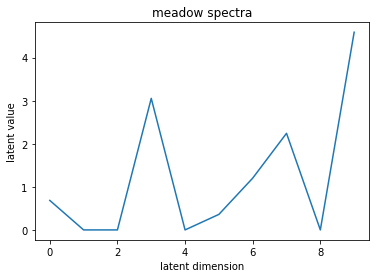

In [22]:
# save plot of latent vector of 'meadow' spectra
fig = plt.figure()
plt.plot(imgZ[576, 210, :])
plt.xlabel('latent dimension')
plt.ylabel('latent value')
plt.title('meadow spectra')

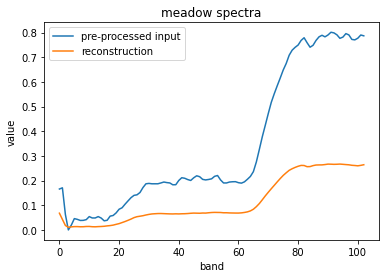

In [23]:
# save plot comparing pre-processed 'meadow' spectra input with decoder reconstruction
fig = plt.figure()
ax = plt.subplot(111)
ax.plot(range(hypData.numBands),imgX[576, 210, :],label='pre-processed input')
ax.plot(range(hypData.numBands),imgY[576, 210, :],label='reconstruction')
plt.xlabel('band')
plt.ylabel('value')
plt.title('meadow spectra')
ax.legend()

In [24]:
 #--------- visualisation ----------------------------------------

 # download dataset ground truth pixel labels (if already downloaded, comment this out).
 urlretrieve( 'http://www.ehu.eus/ccwintco/uploads/5/50/PaviaU_gt.mat',
                         os.path.join(os.getcwd(), 'PaviaU_gt.mat') )

('c:\\Users\\naras\\Model_train\\MLP-Autoenc\\PaviaU_gt.mat',
 <http.client.HTTPMessage at 0x1f6b801ce50>)

In [25]:
# read labels into numpy array
mat_gt = scipy.io.loadmat( 'PaviaU_gt.mat' )
img_gt = mat_gt['paviaU_gt']
gt = np.reshape( img_gt , ( -1 ) )
gt

array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)

In [26]:
imz=imgZ
imz = imz[:,:,0]
imz=imz.reshape(-1)
imz.shape

(207400,)

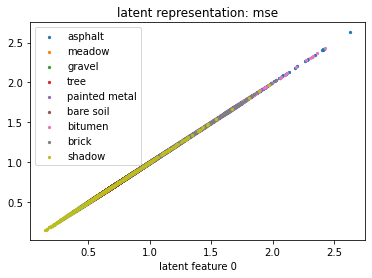

In [27]:
dataZ_collection = [imz]

for j,dataZ in enumerate(dataZ_collection):
    # save a scatter plot image of 2 of 3 latent dimensions
    std_dZ = -np.std(imz,axis=0)
    idx = np.argsort(std_dZ)
    fig, ax = plt.subplots()
    for i,gt_class in enumerate(['asphalt', 'meadow', 'gravel','tree','painted metal','bare soil','bitumen','brick','shadow']):
     ax.scatter(imz[gt == i+1], imz[gt == i+1], c='C%i'%i,s=5,label=gt_class)
    ax.legend()
    plt.title('latent representation: mse')
    plt.xlabel('latent feature %i' % (idx[0]))
#    plt.ylabel('latent feature %i' % (idx[1]))

In [28]:
from math import log10, sqrt
import numpy as np
  
def PSNR(original, compressed):
    mse = np.mean((original - compressed) ** 2)
    if(mse == 0):  # MSE is zero means no noise is present in the signal .
                  # Therefore PSNR have no importance.
        return 100
    max_pixel = 255.0
    psnr = 20 * log10(max_pixel / sqrt(mse))
    return psnr
  
def main():
     original = imgX[576, 210, :]
     compressed = imgY[576, 210, :]
     value = PSNR(original, compressed)
     print(f"PSNR value is {value} dB")
       
if __name__ == "__main__":
    main()

PSNR value is 58.79997668905148 dB


In [29]:
psnr=[]
import statistics
for i in range(hypData.numBands):
    original = imgX[:, :, i]
    compressed = imgY[:, :, i]
    value = PSNR(original, compressed)
    psnr.append(value)
    
print(f" Mean PSNR value is {statistics.mean(psnr)} dB")

 Mean PSNR value is 61.9433645431051 dB


In [30]:
from skimage.metrics import structural_similarity
##skimage.metrics.
import argparse
import imutils
import cv2



# 3. Load the two input images
imageA = imgX[:, :, 1]
imageB = imgY[:, :, 1]

# 4. Convert the images to grayscale
#grayA = cv2.cvtColor(imageA, cv2.COLOR_BGR2GRAY)
#grayB = cv2.cvtColor(imageB, cv2.COLOR_BGR2GRAY)


# 5. Compute the Structural Similarity Index (SSIM) between the two
#    images, ensuring that the difference image is returned
(score, diff) = structural_similarity(imageA, imageB, full=True)
diff = (diff * 255).astype("uint8")

# 6. You can print only the score if you want
print("SSIM: {}".format(score))



SSIM: 0.41774957096786874


d:\Anaconda\lib\site-packages\skimage\_shared\utils.py:348: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  return func(*args, **kwargs)


In [31]:
from skimage.metrics import structural_similarity
##skimage.metrics.
import argparse
import imutils
import cv2

ssim_score=[]
import statistics
for i in range(hypData.numBands):
    # 3. Load the two input images
    imageA = imgX[:, :, i]
    imageB = imgY[:, :, i]

    # 4. Convert the images to grayscale
    #grayA = cv2.cvtColor(imageA, cv2.COLOR_BGR2GRAY)
    #grayB = cv2.cvtColor(imageB, cv2.COLOR_BGR2GRAY)


    # 5. Compute the Structural Similarity Index (SSIM) between the two
    #    images, ensuring that the difference image is returned
    (score, diff) = structural_similarity(imageA, imageB, full=True)
    diff = (diff * 255).astype("uint8")
    ssim_score.append(score)

# 6. You can print only the score if you want
print("SSIM: {}".format(score))
print(f"Mean SSIM {statistics.mean(ssim_score)} dB")




SSIM: 0.4358286183499265
Mean SSIM 0.4674687395732567 dB


In [31]:
tensory=dataY.reshape(hypData.numRows, hypData.numCols, -1)
tensorx=torch.Tensor(imgX)

In [32]:
def cross_correlation(H_fuse, H_ref):
    N_spectral = H_fuse.shape[2]

    # Rehsaping fused and reference data
    H_fuse_reshaped = H_fuse.view(N_spectral, -1)
    H_ref_reshaped = H_ref.view(N_spectral, -1)

    # Calculating mean value
    mean_fuse = torch.mean(H_fuse_reshaped, 1).unsqueeze(1)
    mean_ref = torch.mean(H_ref_reshaped, 1).unsqueeze(1)

    CC = torch.sum((H_fuse_reshaped- mean_fuse)*(H_ref_reshaped-mean_ref), 1)/torch.sqrt(torch.sum((H_fuse_reshaped- mean_fuse)**2, 1)*torch.sum((H_ref_reshaped-mean_ref)**2, 1))

    CC = torch.mean(CC)
    return CC
cross_correlation(tensorx.cpu(),tensory.cpu())

tensor(0.9963, grad_fn=<MeanBackward0>)

In [34]:
def SAM(H_fuse, H_ref):
    #Compute number of spectral bands
    N_spectral = H_fuse.shape[2]

    # Rehsaping fused and reference data
    H_fuse_reshaped = H_fuse.view(N_spectral, -1)
    H_ref_reshaped  = H_ref.view(N_spectral, -1)
    N_pixels = H_fuse_reshaped.shape[1]
    
    # Calculating inner product
    inner_prod  = torch.nansum(H_fuse_reshaped*H_ref_reshaped, 0)
    fuse_norm   = torch.nansum(H_fuse_reshaped**2, dim=0).sqrt()
    ref_norm    = torch.nansum(H_ref_reshaped**2, dim=0).sqrt()

    # Calculating SAM
    SAM = torch.rad2deg(torch.nansum( torch.acos(inner_prod/(fuse_norm*ref_norm)) )/N_pixels)
    return SAM
SAM(tensorx.cpu(),tensory.cpu())

tensor(3.0614, grad_fn=<Rad2DegBackward0>)

In [35]:
def RMSE(H_fuse, H_ref):
    # Rehsaping fused and reference data
    H_fuse_reshaped = H_fuse.view(-1)
    H_ref_reshaped = H_ref.view(-1)

    # Calculating RMSE
    RMSE = torch.sqrt(torch.nansum((H_ref_reshaped - H_fuse_reshaped)**2)/H_fuse_reshaped.shape[0])
    return RMSE
RMSE(tensorx.cpu(),tensory.cpu())

tensor(0.2730, grad_fn=<SqrtBackward0>)

In [36]:
# Peak SNR (PSNR)
def PSNR2(H_fuse, H_ref):
    #Compute number of spectral bands
    N_spectral = H_fuse.shape[2]

    # Reshaping images
    H_fuse_reshaped = H_fuse.view(N_spectral, -1)
    H_ref_reshaped = H_ref.view(N_spectral, -1)

    # Calculating RMSE of each band
    rmse = torch.sqrt(torch.sum((H_ref_reshaped-H_fuse_reshaped)**2, dim=1)/H_fuse_reshaped.shape[1])

    # Calculating max of H_ref for each band
    max_H_ref, _ = torch.max(H_ref_reshaped, dim=1)

    # Calculating PSNR
    PSNR = torch.nansum(10*torch.log10(torch.div(max_H_ref, rmse)**2))/N_spectral

    return PSNR
PSNR2(tensorx.cpu(),tensory.cpu()) 

tensor(2.5352, grad_fn=<DivBackward0>)